In [1]:
import os
import sys
sys.path.append('../')

import lightgbm as lgb
import neptune
from neptunecontrib.monitoring.lightgbm import neptune_monitor
from neptunecontrib.monitoring.reporting import plot_prediction_distribution
import numpy as np
import pandas as pd
import swifter
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
import scikitplot.metrics as sk_metrics 
import matplotlib.pyplot as plt

from src.features.utils import md5_hash, get_filepaths
from src.models.consts import NUMERICAL_COLUMNS, CATEGORICAL_COLUMNS

TRAIN_IDX_PATH = '../data/processed/train_idx.csv'
VALID_IDX_PATH = '../data/processed/valid_idx.csv'
FEATURES_PATH = '../data/processed/features_joined_v1.csv'
MODEL_DIRPATH = '../models/weights'
PREDICTION_DIRPATH = '../models/predictions'
REPORTS_DIRPATH = '../reports'
NROWS=None

NUM_BOOST_ROUND=1000
EARLY_STOPPING_ROUNDS=100
SEED=1234

LGBM_PARAMS = {'metric':'auc',
               'seed': SEED,
                'num_threads': 2,
               'learning_rate':0.014,
               'max_depth': 19,
               'num_leaves': 100,
               'min_data_in_leaf': 102,
               'feature_fraction': 0.27,
               'subsample': 0.912
         }

/home/jakub/miniconda3/envs/py_36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/home/jakub/miniconda3/envs/py_36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train_idx = pd.read_csv(TRAIN_IDX_PATH, nrows=NROWS)
valid_idx = pd.read_csv(VALID_IDX_PATH, nrows=NROWS)
features = pd.read_csv(FEATURES_PATH, nrows=NROWS)

train = pd.merge(train_idx, features, on='SK_ID_CURR')
valid = pd.merge(valid_idx, features, on='SK_ID_CURR')

all_params = {'num_boost_round':NUM_BOOST_ROUND,
              'early_stopping_rounds':EARLY_STOPPING_ROUNDS,
              **LGBM_PARAMS
             }

In [3]:
def train_evaluate(train, valid, params, callbacks=None):
    X_train = train[NUMERICAL_COLUMNS+CATEGORICAL_COLUMNS]
    y_train = train['TARGET']
    X_valid = valid[NUMERICAL_COLUMNS+CATEGORICAL_COLUMNS]
    y_valid = valid['TARGET']

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    model = lgb.train(params,
                          train_data,
                          feature_name=NUMERICAL_COLUMNS+CATEGORICAL_COLUMNS,
                          categorical_feature=CATEGORICAL_COLUMNS,
                          num_boost_round=NUM_BOOST_ROUND,
                          valid_sets = [train_data, valid_data],
                          valid_names=['train_iter', 'valid_iter'],
                          early_stopping_rounds = EARLY_STOPPING_ROUNDS,
                          callbacks=callbacks)
    
    y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
    train_score = roc_auc_score(y_train, y_train_pred)
    train_preds = train[['SK_ID_CURR','TARGET']]
    train_preds['preds_neg'] = 1.0 - y_train_pred
    train_preds['preds_pos'] = y_train_pred

    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    valid_score = roc_auc_score(y_valid, y_valid_pred)
    valid_preds = valid[['SK_ID_CURR','TARGET']]
    valid_preds['preds_neg'] = 1.0 - y_valid_pred
    valid_preds['preds_pos'] = y_valid_pred

    return {'train_score':train_score,
            'valid_score':valid_score,
            'train_preds':train_preds,
            'valid_preds':valid_preds,
            'model':model}

CRED-127
https://ui.neptune.ml/neptune-ml/credit-default-prediction/e/CRED-127


/home/jakub/miniconda3/envs/py_36/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/jakub/miniconda3/envs/py_36/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train_iter's auc: 0.664662	valid_iter's auc: 0.655138
Training until validation scores don't improve for 100 rounds.
[2]	train_iter's auc: 0.677002	valid_iter's auc: 0.653441
[3]	train_iter's auc: 0.726773	valid_iter's auc: 0.717244
[4]	train_iter's auc: 0.736272	valid_iter's auc: 0.729628
[5]	train_iter's auc: 0.737873	valid_iter's auc: 0.729625
[6]	train_iter's auc: 0.758652	valid_iter's auc: 0.749992
[7]	train_iter's auc: 0.758408	valid_iter's auc: 0.752287
[8]	train_iter's auc: 0.7604	valid_iter's auc: 0.754683
[9]	train_iter's auc: 0.759496	valid_iter's auc: 0.752608
[10]	train_iter's auc: 0.756976	valid_iter's auc: 0.74945
[11]	train_iter's auc: 0.755055	valid_iter's auc: 0.746898
[12]	train_iter's auc: 0.756554	valid_iter's auc: 0.749833
[13]	train_iter's auc: 0.757604	valid_iter's auc: 0.751716
[14]	train_iter's auc: 0.757539	valid_iter's auc: 0.751602
[15]	train_iter's auc: 0.757567	valid_iter's auc: 0.751524
[16]	train_iter's auc: 0.757578	valid_iter's auc: 0.751164
[17]	

[142]	train_iter's auc: 0.787165	valid_iter's auc: 0.769898
[143]	train_iter's auc: 0.787267	valid_iter's auc: 0.77013
[144]	train_iter's auc: 0.787375	valid_iter's auc: 0.770286
[145]	train_iter's auc: 0.787431	valid_iter's auc: 0.770303
[146]	train_iter's auc: 0.787564	valid_iter's auc: 0.770393
[147]	train_iter's auc: 0.78766	valid_iter's auc: 0.770368
[148]	train_iter's auc: 0.787712	valid_iter's auc: 0.770473
[149]	train_iter's auc: 0.787804	valid_iter's auc: 0.770451
[150]	train_iter's auc: 0.787889	valid_iter's auc: 0.770438
[151]	train_iter's auc: 0.78793	valid_iter's auc: 0.770448
[152]	train_iter's auc: 0.788081	valid_iter's auc: 0.770493
[153]	train_iter's auc: 0.788236	valid_iter's auc: 0.770519
[154]	train_iter's auc: 0.788362	valid_iter's auc: 0.77048
[155]	train_iter's auc: 0.788425	valid_iter's auc: 0.77051
[156]	train_iter's auc: 0.788595	valid_iter's auc: 0.770535
[157]	train_iter's auc: 0.788845	valid_iter's auc: 0.770645
[158]	train_iter's auc: 0.788932	valid_iter's

[280]	train_iter's auc: 0.801143	valid_iter's auc: 0.773807
[281]	train_iter's auc: 0.801237	valid_iter's auc: 0.773793
[282]	train_iter's auc: 0.801364	valid_iter's auc: 0.773768
[283]	train_iter's auc: 0.801492	valid_iter's auc: 0.773831
[284]	train_iter's auc: 0.801557	valid_iter's auc: 0.773854
[285]	train_iter's auc: 0.801697	valid_iter's auc: 0.773884
[286]	train_iter's auc: 0.801741	valid_iter's auc: 0.773884
[287]	train_iter's auc: 0.801792	valid_iter's auc: 0.77389
[288]	train_iter's auc: 0.801829	valid_iter's auc: 0.773903
[289]	train_iter's auc: 0.801975	valid_iter's auc: 0.773945
[290]	train_iter's auc: 0.802017	valid_iter's auc: 0.77397
[291]	train_iter's auc: 0.802096	valid_iter's auc: 0.773982
[292]	train_iter's auc: 0.802167	valid_iter's auc: 0.77402
[293]	train_iter's auc: 0.802223	valid_iter's auc: 0.77407
[294]	train_iter's auc: 0.802363	valid_iter's auc: 0.774062
[295]	train_iter's auc: 0.802392	valid_iter's auc: 0.774112
[296]	train_iter's auc: 0.802513	valid_iter'

[422]	train_iter's auc: 0.81323	valid_iter's auc: 0.775323
[423]	train_iter's auc: 0.813344	valid_iter's auc: 0.775312
[424]	train_iter's auc: 0.813457	valid_iter's auc: 0.7753
[425]	train_iter's auc: 0.81352	valid_iter's auc: 0.775276
[426]	train_iter's auc: 0.813615	valid_iter's auc: 0.775268
[427]	train_iter's auc: 0.813682	valid_iter's auc: 0.775267
[428]	train_iter's auc: 0.813723	valid_iter's auc: 0.775265
[429]	train_iter's auc: 0.813805	valid_iter's auc: 0.775275
[430]	train_iter's auc: 0.813872	valid_iter's auc: 0.775257
[431]	train_iter's auc: 0.813922	valid_iter's auc: 0.775274
[432]	train_iter's auc: 0.813981	valid_iter's auc: 0.775268
[433]	train_iter's auc: 0.814078	valid_iter's auc: 0.775275
[434]	train_iter's auc: 0.814148	valid_iter's auc: 0.775274
[435]	train_iter's auc: 0.814168	valid_iter's auc: 0.775274
[436]	train_iter's auc: 0.814223	valid_iter's auc: 0.775288
[437]	train_iter's auc: 0.814288	valid_iter's auc: 0.775292
[438]	train_iter's auc: 0.814344	valid_iter'

[560]	train_iter's auc: 0.824117	valid_iter's auc: 0.775457
[561]	train_iter's auc: 0.824207	valid_iter's auc: 0.775471
[562]	train_iter's auc: 0.824263	valid_iter's auc: 0.77548
[563]	train_iter's auc: 0.824344	valid_iter's auc: 0.775469
[564]	train_iter's auc: 0.824445	valid_iter's auc: 0.775469
[565]	train_iter's auc: 0.824525	valid_iter's auc: 0.775458
[566]	train_iter's auc: 0.824616	valid_iter's auc: 0.775453
[567]	train_iter's auc: 0.824666	valid_iter's auc: 0.775467
[568]	train_iter's auc: 0.824719	valid_iter's auc: 0.775442
[569]	train_iter's auc: 0.824814	valid_iter's auc: 0.775452
[570]	train_iter's auc: 0.824943	valid_iter's auc: 0.775432
[571]	train_iter's auc: 0.824972	valid_iter's auc: 0.775425
[572]	train_iter's auc: 0.825034	valid_iter's auc: 0.775428
[573]	train_iter's auc: 0.825144	valid_iter's auc: 0.775416
[574]	train_iter's auc: 0.825251	valid_iter's auc: 0.775431
[575]	train_iter's auc: 0.825315	valid_iter's auc: 0.77543
[576]	train_iter's auc: 0.825419	valid_ite

[704]	train_iter's auc: 0.834016	valid_iter's auc: 0.77512
[705]	train_iter's auc: 0.834109	valid_iter's auc: 0.775107
[706]	train_iter's auc: 0.834199	valid_iter's auc: 0.775122
[707]	train_iter's auc: 0.834287	valid_iter's auc: 0.775144
Early stopping, best iteration is:
[607]	train_iter's auc: 0.827604	valid_iter's auc: 0.775489


/home/jakub/miniconda3/envs/py_36/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jakub/miniconda3/envs/py_36/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jakub/miniconda3/envs/py_36/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

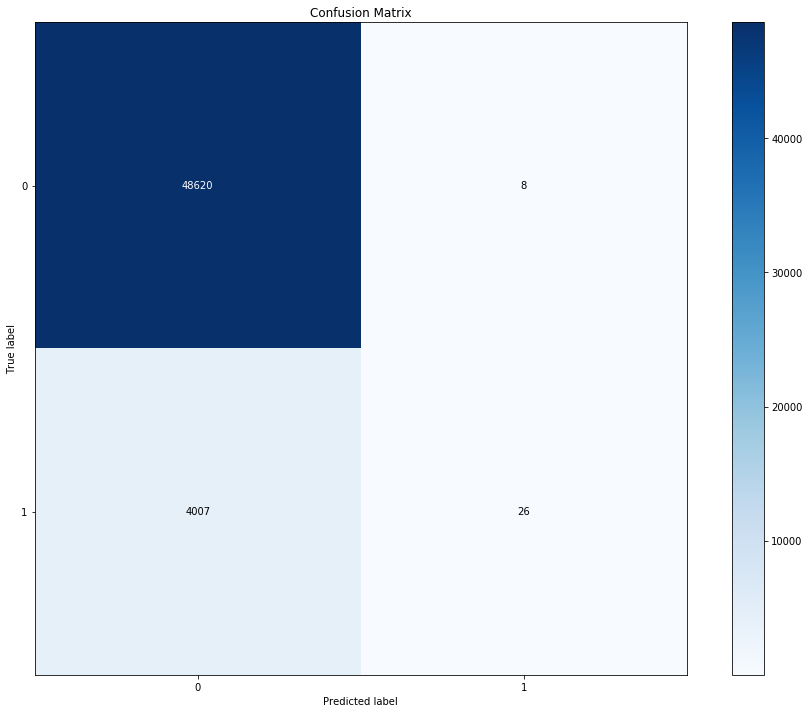

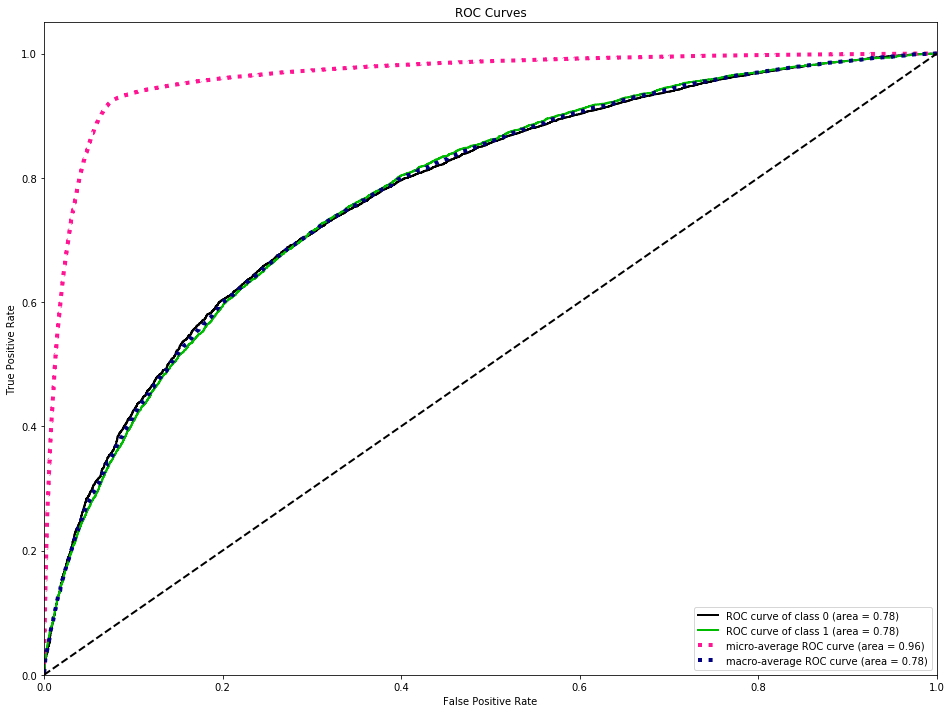

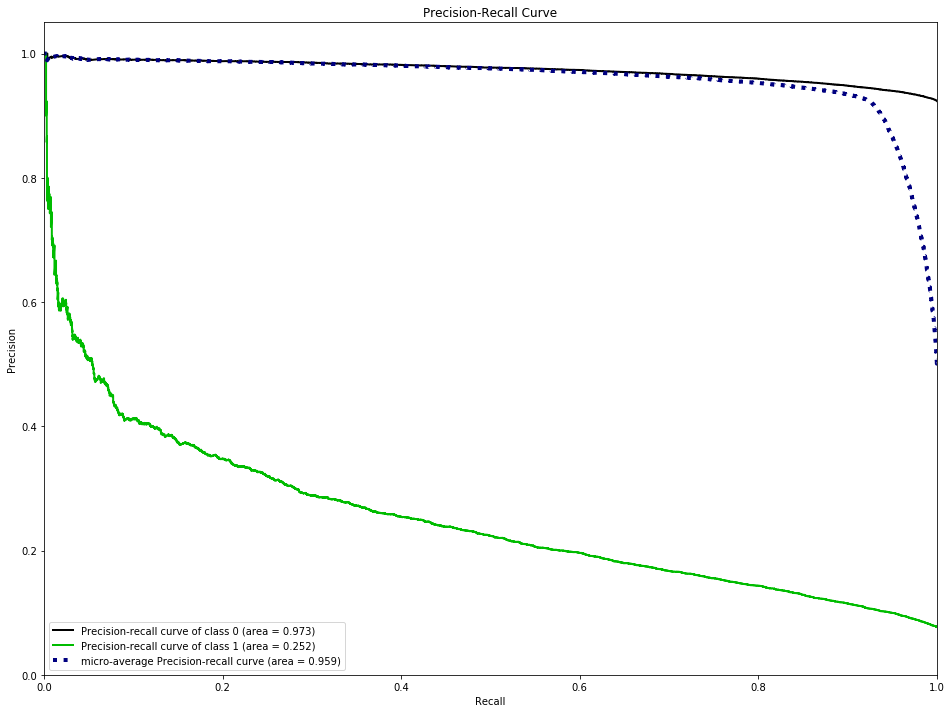

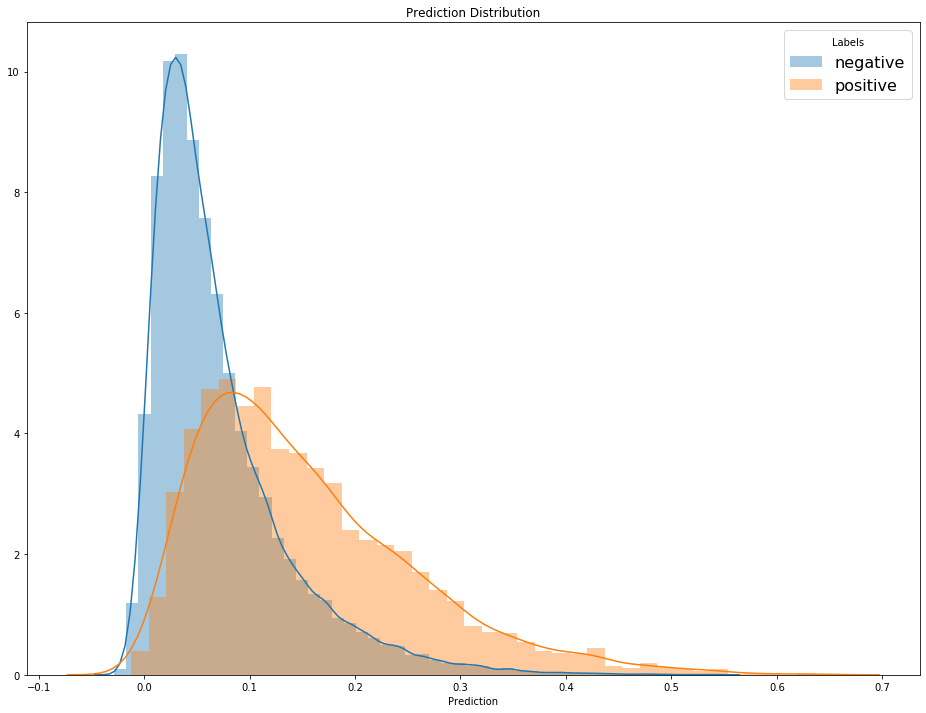

In [5]:
neptune.init('neptune-ml/credit-default-prediction')

with neptune.create_experiment(name='model training',
                               params=all_params,
                               tags=['lgbm'],
                               upload_source_files=get_filepaths(),
                               properties={'features_path':FEATURES_PATH,
                                           'features_version':md5_hash(FEATURES_PATH),
                                           'train_split_version': md5_hash(TRAIN_IDX_PATH),  
                                           'valid_split_version': md5_hash(VALID_IDX_PATH),  
                                          }):

    results = train_evaluate(train, valid, LGBM_PARAMS, callbacks=[neptune_monitor()])
    train_score, valid_score = results['train_score'], results['valid_score']
    train_preds, valid_preds = results['train_preds'], results['valid_preds']

    neptune.send_metric('train_auc', train_score)
    neptune.send_metric('valid_auc', valid_score)

    train_pred_path = os.path.join(PREDICTION_DIRPATH, 'train_preds.csv')
    train_preds.to_csv(train_pred_path, index=None)
    neptune.send_artifact(train_pred_path)

    valid_pred_path = os.path.join(PREDICTION_DIRPATH, 'valid_preds.csv')
    valid_preds.to_csv(valid_pred_path, index=None)
    neptune.send_artifact(valid_pred_path)

    model_path = os.path.join(MODEL_DIRPATH, 'model.pkl')
    joblib.dump(results['model'], model_path)
    neptune.set_property('model_path', model_path)
    neptune.set_property('model_version', md5_hash(model_path))
    neptune.send_artifact(model_path)

    fig, ax = plt.subplots(figsize=(16,12))
    sk_metrics.plot_confusion_matrix(valid_preds['TARGET'], valid_preds['preds_pos']>0.5, ax=ax)
    plot_path = os.path.join(REPORTS_DIRPATH, 'conf_matrix.png')
    fig.savefig(plot_path)
    neptune.send_image('diagnostics', plot_path)

    fig, ax = plt.subplots(figsize=(16,12))
    sk_metrics.plot_roc(valid_preds['TARGET'], valid_preds[['preds_neg','preds_pos']], ax=ax)
    plot_path = os.path.join(REPORTS_DIRPATH, 'roc_auc.png')
    fig.savefig(plot_path)
    neptune.send_image('diagnostics', plot_path)

    fig, ax = plt.subplots(figsize=(16,12))
    sk_metrics.plot_precision_recall(valid_preds['TARGET'], valid_preds[['preds_neg','preds_pos']], ax=ax)
    plot_path = os.path.join(REPORTS_DIRPATH, 'prec_recall.png')
    fig.savefig(plot_path)
    neptune.send_image('diagnostics', plot_path)

    fig, ax = plt.subplots(figsize=(16,12))
    plot_prediction_distribution(valid_preds['TARGET'], valid_preds['preds_pos'], ax=ax)
    plot_path = os.path.join(REPORTS_DIRPATH, 'preds_dist.png')
    fig.savefig(plot_path)
    neptune.send_image('diagnostics', plot_path)